In [54]:
import os 
import nibabel as nib
import numpy as np

from bids.layout import BIDSLayout

from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table


gradient_layout = BIDSLayout("./openneuro/ds001907", validate=False)

subj = 'RC4101'

dwi_fname = gradient_layout.get(subject=subj, suffix='dwi', extension='.nii.gz', return_type='file')[0]
bvec_fname = gradient_layout.get(subject=subj, extension='.bvec', return_type='file')[0]
bval_fname = gradient_layout.get(subject=subj, suffix='dwi', extension='.bval', return_type='file')[0]

dwi_img = nib.load(dwi_fname)
affine = dwi_img.affine

bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
gtab = gradient_table(bvals, bvecs)
t1_load = nib.load("./openneuro/ds001907/sub-RC4101/ses-2/anat/sub-RC4101_ses-2_T1w.nii.gz")
t1_data = t1_load.get_fdata()



In [55]:
import numpy as np
import nibabel as nib
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel
from dipy.direction import DeterministicMaximumDirectionGetter
from dipy.tracking import local_tracking
from dipy.tracking.utils import streamline_near_roi
from dipy.tracking.streamline import Streamlines
import matplotlib.pyplot as plt


data = dwi_img.get_fdata()

gtab = gradient_table(bvals, bvecs)

# Preprocess DWI data as needed

# Diffusion modeling
tensor_model = TensorModel(gtab)
tensor_fit = tensor_model.fit(data)

# Define seed coordinates based on MNI template
seed_coords = [
    (0, -2, -24),  # Seed region 1: Coordinates in MNI space (x, y, z)
    (28, -34, -4),  # Seed region 2: Coordinates in MNI space (x, y, z)
    # Add more seed region coordinates as needed
]

# Calculate connectivity matrix
num_seeds = len(seed_coords)
connectivity_matrix = np.zeros((num_seeds, num_seeds))

for i in range(num_seeds):
    seed_coord = seed_coords[i]
    
    # Perform fiber tracking from seed region
    sphere = tensor_model.sphere
    direction_getter = DeterministicMaximumDirectionGetter.from_shcoeff(tensor_model.fit(data).predict(), max_angle=30., sphere=sphere)
    streamlines_generator = local_tracking(direction_getter, seed_coord, tensor_model, step_size=0.5)
    streamlines = Streamlines(streamlines_generator)
    
    # Count the number of streamlines connecting the seed region to other regions
    for j in range(num_seeds):
        target_coord = seed_coords[j]
        
        streamline_count = 0
        
        for streamline in streamlines:
            if streamline_near_roi(streamline, target_coord, threshold=2):
                streamline_count += 1
        
        connectivity_matrix[i, j] = streamline_count

# Plot the connectivity matrix as a heatmap
plt.imshow(connectivity_matrix, cmap='viridis')
plt.colorbar()
plt.title('Connectivity Matrix')
plt.xlabel('Seed Regions')
plt.ylabel('Seed Regions')
plt.xticks(range(num_seeds), range(1, num_seeds + 1))  # Use numbers as seed labels
plt.yticks(range(num_seeds), range(1, num_seeds + 1))
plt.show()


AttributeError: 'TensorModel' object has no attribute 'sphere'

In [ ]:
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu

dwi_data = dwi_img.get_fdata()
dwi_data, dwi_mask = median_otsu(dwi_data, vol_idx=[0], numpass=1)  # Specify the volume index to the b0 volumes

dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(dwi_data, mask=dwi_mask)  # This step may take a while

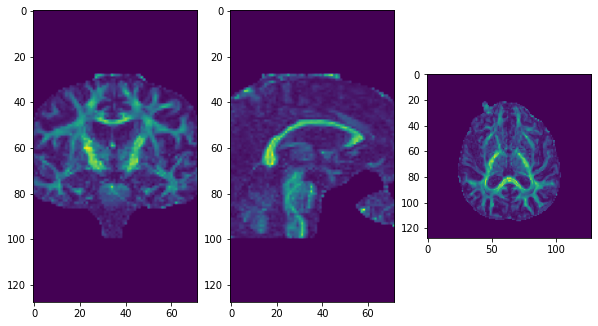

(128, 128, 72)

In [ ]:
# Create the directory to save the results

out_dir = f"./outDir/sub-{subj}/ses-02/dwi/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

fa_img = dti_fit.fa
evecs_img = dti_fit.evecs

fa_img[np.isnan(fa_img)] = 0

# Save the FA
fa_nii = nib.Nifti1Image(fa_img.astype(np.float32), affine)
nib.save(fa_nii, os.path.join(out_dir, 'fa.nii.gz'))

# Plot the FA
import matplotlib.pyplot as plt
from scipy import ndimage  # To rotate image for visualization purposes

%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(ndimage.rotate(fa_img[:, fa_img.shape[1]//2, :], 90, reshape=False))
ax[1].imshow(ndimage.rotate(fa_img[fa_img.shape[0]//2, :, :], 90, reshape=False))
ax[2].imshow(ndimage.rotate(fa_img[:, :, fa_img.shape[-1]//2], 90, reshape=False))
fig.savefig(os.path.join(out_dir, "fa.png"), dpi=300, bbox_inches="tight")
plt.show()

fa_img.shape

In [ ]:
from dipy.data import get_sphere

sphere = get_sphere('symmetric362')


In [ ]:
from dipy.direction import peaks_from_model

peak_indices = peaks_from_model(
    model=dti_model, data=dwi_data, sphere=sphere, relative_peak_threshold=.2,
    min_separation_angle=25, mask=dwi_mask, npeaks=2)


In [ ]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(fa_img, .2)


In [ ]:
from dipy.tracking import utils

seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=affine, density=1)


In [ ]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialize local tracking - computation happens in the next step.
streamlines_generator = LocalTracking(
    peak_indices, stopping_criterion, seeds, affine=affine, step_size=.5)

# Generate streamlines object
streamlines = Streamlines(streamlines_generator)


In [ ]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram

sft = StatefulTractogram(streamlines, dwi_img, Space.RASMM)

# Save the tractogram
save_tractogram(sft, os.path.join(out_dir, "tractogram_deterministic_EuDX.trk"))


True

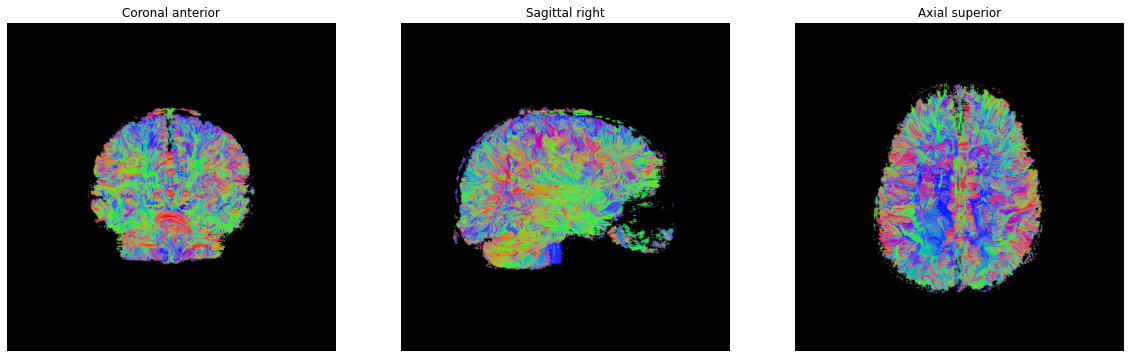

In [ ]:
from fury import actor, colormap
from utils_folder.visualization_utils import generate_anatomical_volume_figure

# Plot the tractogram

# Build the representation of the data
streamlines_actor = actor.line(streamlines, colormap.line_colors(streamlines))

# Generate the figure
fig = generate_anatomical_volume_figure(streamlines_actor)

fig.savefig(os.path.join(out_dir, "tractogram_deterministic_EuDX.png"),
            dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
cc_slice = dwi_mask
cc_streamlines = utils.target(streamlines, affine, dwi_mask)
cc_streamlines = Streamlines(cc_streamlines)

other_streamlines = utils.target(streamlines, affine, dwi_mask,
                                 include=False)
other_streamlines = Streamlines(other_streamlines)
assert len(other_streamlines) + len(cc_streamlines) == len(streamlines)

In [ ]:

from fury import window, actor, colormap as cmap

# Enables/disables interactive visualization


# Make display objects
color = cmap.line_colors(cc_streamlines)
cc_streamlines_actor = actor.line(cc_streamlines,
                                  cmap.line_colors(cc_streamlines))
cc_ROI_actor = actor.contour_from_roi(cc_slice, color=(1., 1., 0.),
                                      opacity=0.5)

vol_actor = actor.slicer(t1_data)

vol_actor.display(x=40)
vol_actor2 = vol_actor.copy()
vol_actor2.display(z=35)

# Add display objects to canvas
r = window.Scene()
r.add(vol_actor)
r.add(vol_actor2)
r.add(cc_streamlines_actor)
r.add(cc_ROI_actor)

# Save figures


window.show(r)
r.set_camera(position=[-1, 0, 0], focal_point=[0, 0, 0], view_up=[0, 0, 1])



In [ ]:
M, grouping = utils.connectivity_matrix(cc_streamlines, affine, labels,
                                        return_mapping=True,
                                        mapping_as_streamlines=True)
M[:3, :] = 0
M[:, :3] = 0

ValueError: label_volume must be a 3d integer array withnon-negative label values